In [1]:
import glob
import json
import os
import random
import shutil

import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm


output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

### 1. Data preprocessing
+ 1.1 observation and cleaning
+ 1.2 splitting
+ 1.3 numpy or dataloader

+ download: [Kaggle link](https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip)
+ more:
    + Image augmentation
    + Pretrain model
    + Cross entropy loss
    + Confusion matrix

In [2]:
# check the number of each class
cat_path_list = glob.glob("./train/cat*.jpg")
dog_path_list = glob.glob("./train/dog*.jpg")
len(cat_path_list), len(cat_path_list)

(12500, 12500)

In [3]:
# splitting + create links
seed = 0
random.seed(seed)
sample_each_class = 100
n_train = int(sample_each_class * 0.8)


cat_path_list_sampled = random.sample(cat_path_list, sample_each_class)
dog_path_list_sampled = random.sample(dog_path_list, sample_each_class)
path_list_dict = {
    "train": {
        "cat": cat_path_list_sampled[:n_train],
        "dog": dog_path_list_sampled[:n_train],
    },
    "valid": {
        "cat": cat_path_list_sampled[n_train:],
        "dog": dog_path_list_sampled[n_train:],
    }
}


for mode in ["train", "valid"]:
    for cls in ["cat", "dog"]:
        os.makedirs(f"dataset/{mode}/{cls}", exist_ok=True)
        for path in path_list_dict[mode][cls]:
            shutil.copy(path, f"dataset/{mode}/{cls}/{os.path.basename(path)}")

In [20]:
class DirectoryClassificationDataset(Dataset):
    """
    The dataset should be organized like:
    path/
        class1/
            img1.jpg
            img2.jpg
            ...
        class2/
            img1.jpg
            img2.jpg
    """
    def __init__(self, path: str):
        self.class_list = sorted(os.listdir(path))
        self.path_list = glob.glob(f"{path}/*/*.jpg")
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((128, 128)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 1-v, 1+v
            ]
        )

    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, index: int):
        """
        Args:
            index (int)
        Returns:
            x (torch.Tensor float): image, shape = (3, h, w)
            y (torch.Tensor int): class index 
        """
        x = cv2.imread(self.path_list[index]) / 255.
        x = self.transform(x)  # (h, w, c) -> (c, h, w)
        x = x.type(torch.float32)
        class_name = self.path_list[index].split("/")[-2]
        y = torch.Tensor([self.class_list.index(class_name)]).type(torch.int64)
        return x, y


trainset = DirectoryClassificationDataset("dataset/train")
validset = DirectoryClassificationDataset("dataset/valid")
trainset[0][0].shape, trainset[0][1]

(torch.Size([3, 128, 128]), tensor([0]))

In [5]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=False, shuffle=False)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=False, shuffle=False)

### 2. Model prepatation
+ 2.1 model
+ 2.2 loss
+ 2.3 more hyperparameters

In [11]:
# model
model_name = "simple_cnn"
#model_name = "resnet18"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
class SimpleCNN(torch.nn.Module):
    def __init__(
            self,
            input_c: int,
            input_h: int,
            input_w: int,
            num_output_features: int,
            hidden_cnn: int = 64,
        ):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=input_c, out_channels=hidden_cnn, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=hidden_cnn, out_channels=hidden_cnn, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=hidden_cnn, out_channels=hidden_cnn, kernel_size=3, stride=1, padding=1)
        self.dense1 = torch.nn.Linear(input_h * input_w * hidden_cnn // 64, num_output_features)

        self.relu   = torch.nn.ReLU()
        self.maxpool= torch.nn.MaxPool2d(2)
        self.flatten = torch.nn.Flatten()
        # don't do softmax, since nn.functional.CrossEntropyLoss will do

    def forward(self, x):  # (B, 3, 128, 128)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 16, 64, 64)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 16, 32, 32)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 16, 16, 16)
        x = self.flatten(x)  # (B, 4096)
        x = self.dense1(x)  # (B, 2)
        return x


if model_name == "simple_cnn":
    model = SimpleCNN(3, 128, 128, 2, 16).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    example_x, example_y = next(iter(trainset))
    print(model(example_x.unsqueeze(0)).shape)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Linear(in_features=4096, out_features=2, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
num_parameters: 13282
torch.Size([1, 2])


In [13]:
class ResNet18(torch.nn.Module):
    def __init__(self, num_output_features: int):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True).to(device)
        in_features = self.resnet18.fc.in_features
        self.backbone.fc = torch.nn.Linear(in_features, num_output_features)

    def forward(self, x):  # (B, 3, h, w)
        return self.resnet18(x)  # (B, 2)

if model_name == "resnet18":
    model = SimpleCNN(3, 128, 128, 2, 32).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    example_x, example_y = next(iter(trainset))
    print(model(example_x.unsqueeze(0)).shape)

In [23]:
# loss
loss_func = torch.nn.CrossEntropyLoss()

# more hyperparama
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
save_ckpts_per_epochs = 30

### 3. Training
+ 3.1 epoch: train loop, valid loop, save ckpts and loss
+ 3.2 check convergence

In [24]:
history = {"train_loss_list": [], "valid_loss_list": []}
pbar = tqdm(range(epochs))
for epoch in pbar:
    # training loop
    train_loss= 0.
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()      # 1. zero the parameter gradients
        pred = model(x)            # 2. f(x) and f'(x)
        loss = loss_func(pred, y.reshape(-1))  # 3. compute loss
        loss.backward()            # 4. send loss to torch
        optimizer.step()           # 5. update model parameters by torch loss 
        train_loss += loss.item() / len(trainset)
        
    # validation
    valid_loss = 0.
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_func(pred, y.reshape(-1))
            valid_loss += loss.item() / len(validset)

    # save
    history["train_loss_list"].append(train_loss)
    history["valid_loss_list"].append(valid_loss)
    with open(os.path.join(output_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)
    if valid_loss == min(history["valid_loss_list"]):
        torch.save(model.state_dict(), os.path.join(output_dir, "best.pt"))
    elif (epoch + 1) % save_ckpts_per_epochs == 0:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"epoch_{str(epoch).zfill(3)}.pt")
        )
    pbar.set_description(f"train_loss: {train_loss:.4f}, val_loss: {valid_loss:.4f}")

train_loss: 0.0434, val_loss: 0.0525: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


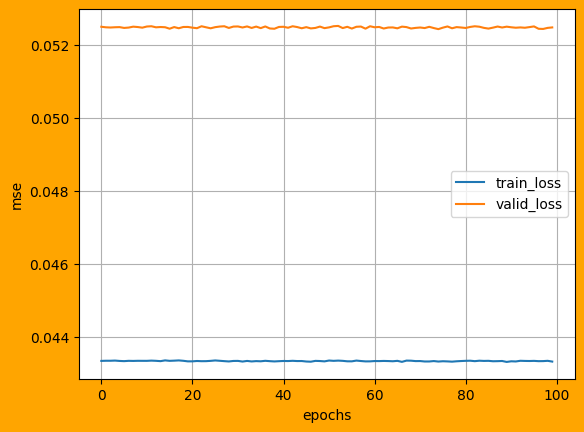

In [19]:
# check convergence
history = json.load(open(os.path.join(output_dir, "history.json")))
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['train_loss_list'], label='train_loss')
plt.plot(history['valid_loss_list'], label='valid_loss')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

### 4. Prediction
+ 4.1 testset
+ 4.2 (optional) metrics
+ 4.3 (optional) data improvement

In [ ]:
# load checkpoints and inference

ckpt_path = os.path.join(output_dir, "best.pt")
train_dataset_result = train_dataset.copy().apply(np.exp)
trainloader = trainloader
valid_dataset_result = valid_dataset.copy().apply(np.exp)
validloader = validloader

model = SimpleCNN(
        window_size,
        num_input_features,
        num_output_features,
        hidden_size = 32
    ).to(device)
# model = ToyTransformerEncoder(
#         window_size,
#         num_input_features,
#         num_output_features,
#     ).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()
loss_func = torch.nn.MSELoss(reduction="none")

for dataset_result, loader, name in [
        (train_dataset_result, trainloader, "train"),
        (valid_dataset_result, validloader, "valid")
    ]:
    prediction_list = []
    loss_list = []
    for x, y in loader:
        with torch.no_grad():
            pred = model(x)
            loss = loss_func(pred, y)
            prediction_list.append(pred.cpu().numpy().squeeze())  # (B, 1) -> (B,)
            loss_list.append(loss.cpu().numpy().squeeze())  # (B, 1) -> (B,)
    preds = np.concatenate(prediction_list)  # (N, num_output_features)
    preds_repeat = np.repeat(preds, window_size, axis=0)  # (window_size * N, num_output_features)
    loss = np.concatenate(loss_list)
    loss_repeat = np.repeat(loss, window_size, axis=0)
    dataset_result[[f"pred_{i}" for i in range(num_output_features)]] = preds_repeat
    dataset_result[[f"loss_{i}" for i in range(num_output_features)]] = loss_repeat
    dataset_result.to_csv(os.path.join(output_dir, f"{name}_dataset_result.csv"))
    print(dataset_result)

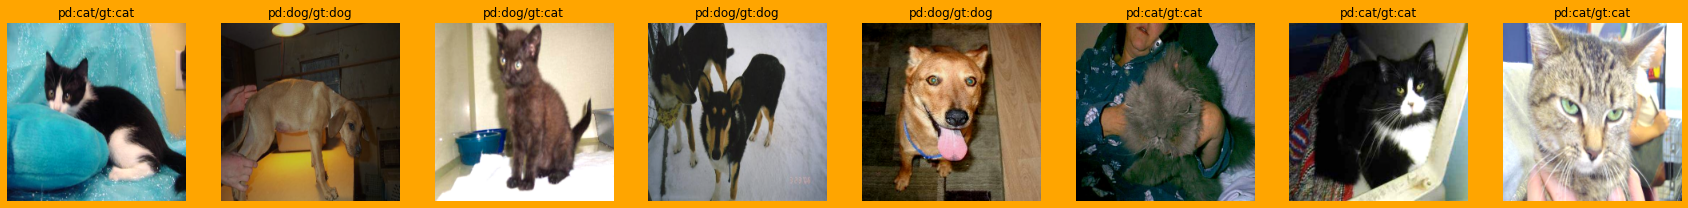

[[2052, 1092], [388, 1468]]


In [ ]:
# (optional) metrics

confusion = [[0,0], [0,0]] # [[d->d,c->d],[d->c,c->c]] 
with torch.no_grad():
    for i,(X,y) in enumerate(valDataLoader):
        pred = model(X)
        ypred = pred.argmax(axis=1)
        if i==0:
            XLast = (X.permute(0,2,3,1).cpu().numpy()*255).astype(int)
            ax = plt.figure(figsize=(30,2*3))
            ax.set_facecolor("orange")
            for j in range(8):
                plt.subplot(1,8,j+1)
                plt.title(f"pd:{'dog' if int(ypred[j])==0 else 'cat'}/gt:{'dog' if int(y[j])==0 else 'cat'}")
                plt.imshow( XLast[j,:,:,::-1] )
                plt.axis('off')
            plt.show()
        for yp,yt in zip(ypred.cpu().numpy(),y.squeeze()):
            confusion[yp][yt]+=1
print(confusion)

In [ ]:
# (optional) data improvement